# moment predictions

In [95]:
#Import
import sys
sys.path.append("../lib")
import basicfunc as func
import plotlib as plib

import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = 12, 16
import pymaster as nmt
import healpy as hp
import pysm3
import pysm3.units as u
import simu_lib as sim
import scipy.stats as st

def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

def compute_cl(mapd,mask,b):
    fa1 = nmt.NmtField(mask, (mapd)*mask,purify_e=False, purify_b=True)
    wsp = nmt.NmtWorkspace()
    wsp.compute_coupling_matrix(fa1, fa1, b)
    return compute_master(fa1,fa1,wsp)        

def compute_cross_cl(mapd1,mapd2,mask,b):
    fa1 = nmt.NmtField(mask, (mapd1)*mask,purify_e=False, purify_b=True)
    fa2 = nmt.NmtField(mask, (mapd2)*mask,purify_e=False, purify_b=True)
    wsp = nmt.NmtWorkspace()
    wsp.compute_coupling_matrix(fa1, fa2, b)
    return compute_master(fa1,fa2,wsp) 

def plotmed(ell,label,res,color='darkblue',marker="D",show=True,legend=''):
    """
    Plot median and median absolute deviation of best-fits as a function of ell
    :ell: bandpower array
    :label: string indicating the name of the quantity
    :color: color of the plot
    :marker: marker of the plot
    :show: show the plot
    legend: legend to add to the plot
    """
    ellbound=ell.shape[0]
    name={'A':r'$A^d$','beta':r'$\beta^d$','temp':r'$T^d$','beta_s':r'$\beta^s$','A_s':r'$A^s$','A_sd':r'$A^{sd}$','r':r'$\hat{r}$','X2red':r'$\chi^2$','Aw1b':r'$\mathcal{D}_\ell^{A\times\omega_1^{\beta}}$','Aw1t':r'$\mathcal{D}_\ell^{A\times\omega_1^{T}}$','Asw1bs':r'$\mathcal{D}_\ell^{A_s\times\omega_1^{\beta^s}}$','w1bw1s':r'$\mathcal{D}_\ell^{\omega_1^{\beta^d}\times\omega_1^{\beta^s}}$','w1sw1T':r'$\mathcal{D}_\ell^{\omega_1^{T^d}\times\omega_1^{\beta^s}}$','w1bw1b':r'$\mathcal{D}_\ell^{\omega_1^\beta\times\omega_1^\beta}$','w1tw1t':r'$\mathcal{D}_\ell^{\omega_1^T\times\omega_1^T}$','w1bw1t':r'$\mathcal{D}_\ell^{\omega_1^\beta\times\omega_1^T}$','w1bsw1bs':r'$\mathcal{D}_\ell^{\omega_1^{\beta^s}\times\omega_1^{\beta^s}}$', 'Asw1b':r'$\mathcal{D}_\ell^{A_s\times\omega_1^{\beta}}$','Asw1t':r'$\mathcal{D}_\ell^{A_s\times\omega_1^{T}}$','Adw1s':r'$\mathcal{D}_\ell^{A\times\omega_1^{\beta^s}}$'}
    edgecolor="#80AAF3"
    plt.errorbar(ell,np.median(res[label],axis=1)[:ellbound],yerr=st.median_abs_deviation(res[label],axis=1)[:ellbound],c=color,fmt=marker,linestyle='',label=legend)
    plt.scatter(ell,np.median(res[label],axis=1)[:ellbound],s=175,c=color,marker=marker,edgecolor=edgecolor)
    plt.ylabel(name[label],fontsize=20)
    plt.xlabel(r"$\ell$",fontsize=20)
    plt.legend()
    plt.tight_layout()
    if show==True:
        plt.show()


In [55]:
#choose frequency range

dusttype=10
instr= 'LiteBIRD'
nside=64
scale=10
fsky=0.7
Nlbin = 10
lmax = nside*3-1
mask = hp.read_map("../masks/mask_fsky%s_nside%s_aposcale%s.npy"%(fsky,nside,scale))
b = nmt.bins.NmtBin(nside=nside,lmax=lmax,nlb=Nlbin)
leff = b.get_effective_ells()

if instr=='Planck':
    freq=np.array([100,143,217,353])
if instr=='LiteBIRD':
    freq=np.array([ 40.,  50.,  60.,  68.,  78.,  89., 100., 119., 140., 166., 195.,235., 280., 337., 402.])

sky = pysm3.Sky(nside=512, preset_strings=['d%s'%dusttype])
dust = sky.components[0]
betamap =dust.mbb_index.value
tempmap=dust.mbb_temperature.value
nu0=dust.freq_ref_P.value
skyref = sky.get_emission(nu0 * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0*u.GHz)).value
model= np.array([sky.get_emission(freq[f] * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq[f]*u.GHz)).value for f in range(len(freq))])

In [56]:
skyrefcpx=skyref[1]+1j*skyref[2]
betabar= 1.54
tempbar=20

In [57]:
mom1b = skyrefcpx*(betamap-betabar)
mom2b = skyrefcpx*(betamap-betabar)**2
mom1t = skyrefcpx*(tempmap-tempbar)
mom2t = skyrefcpx*(tempmap-tempbar)**2
mom2bt= skyrefcpx*(tempmap-tempbar)*(betamap-betabar)

In [74]:
def getmom_downgr(mom):
    momarr=np.array([np.zeros(hp.nside2npix(512)),mom.real,mom.imag])
    momdg=sim.downgrade_map(momarr,nside_in=512,nside_out=nside)
    return momdg
def get_dl_bb_mom(map1,map2):
    return leff*(leff+1)*compute_cross_cl(getmom_downgr(map1)[1:],getmom_downgr(map2)[1:],mask,b)[3]/2/np.pi

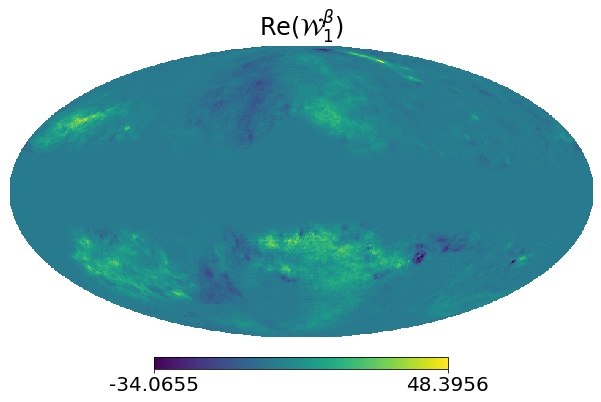

In [124]:
hp.mollview(getmom_downgr(mom1b)[1]*mask,title=r'${\rm Re}(\mathcal{W}_1^\beta)$')

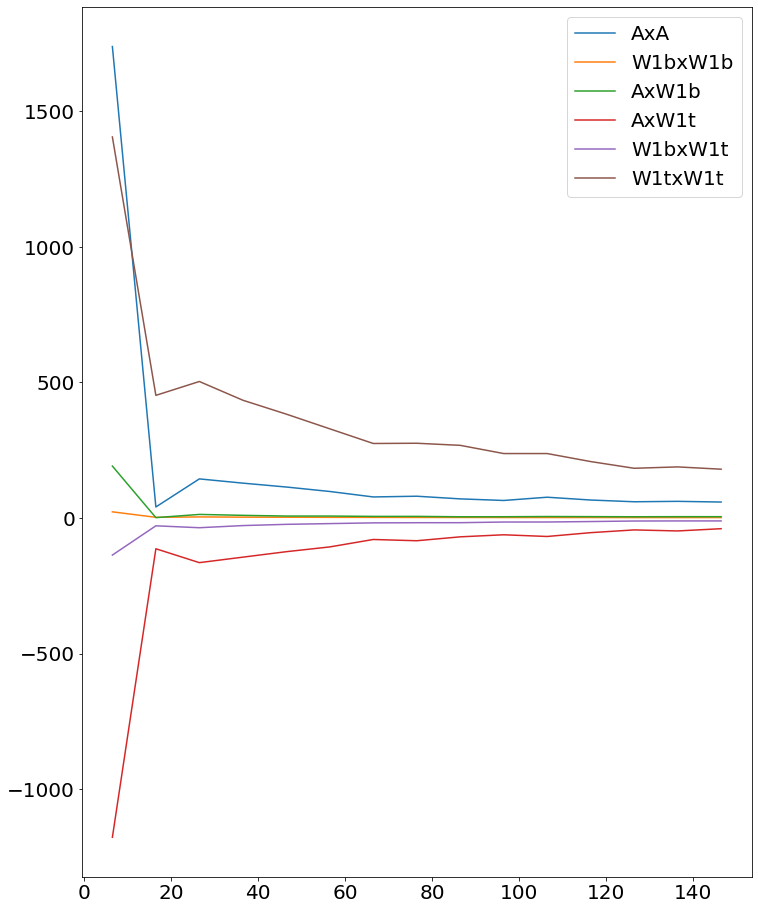

In [125]:
plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,skyrefcpx)[:15],label='AxA')
plt.plot(leff[:15],get_dl_bb_mom(mom1b,mom1b)[:15],label='W1bxW1b')
plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,mom1b)[:15],label='AxW1b')
plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,mom1t)[:15],label='AxW1t')
plt.plot(leff[:15],get_dl_bb_mom(mom1b,mom1t)[:15],label='W1bxW1t')
plt.plot(leff[:15],get_dl_bb_mom(mom1t,mom1t)[:15],label='W1txW1t')
#plt.plot(leff[:15],get_dl_bb_mom(mom2b,mom2b)[:15],label='W2bxW2b')
#plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,mom2b)[:15],label='AxW2b')
#plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,mom2t)[:15],label='AxW2t')
#plt.plot(leff[:15],get_dl_bb_mom(mom2b,mom2t)[:15],label='W2bxW2t')
#plt.plot(leff[:15],get_dl_bb_mom(mom2t,mom2t)[:15],label='W2txW2t')
#plt.plot(leff[:15],get_dl_bb_mom(mom2bt,mom2bt)[:15],label='W2btxW2bt')
plt.legend()

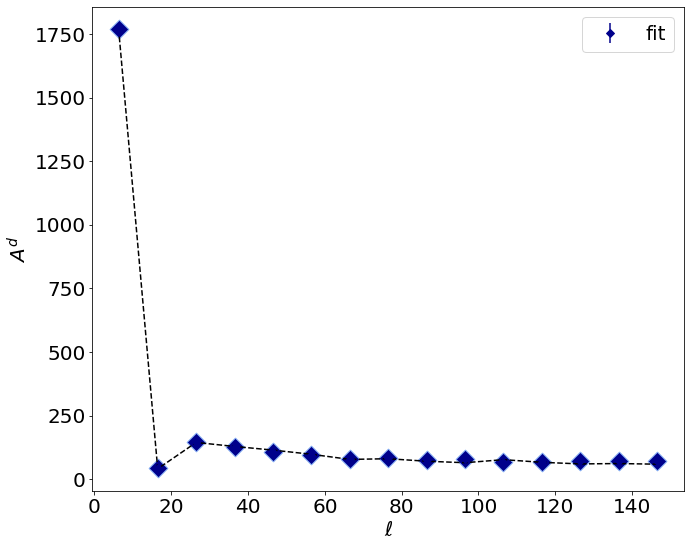

In [104]:
res=np.load('../Best-fits/results_d%ss%s_0.7_o1bt.npy'%(1,0),allow_pickle=True).item()
plt.figure(figsize=(10,8))
plotmed(leff[:15],'A',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,skyrefcpx)[:15],c='k',linestyle='--',label='analytical')
plt.show()

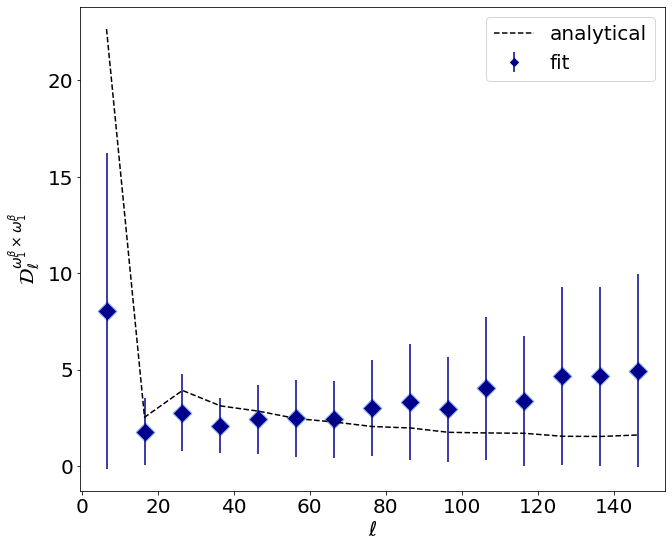

In [126]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'w1bw1b',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],get_dl_bb_mom(mom1b,mom1b)[:15],c='k',linestyle='--',label='analytical')
plt.legend()
plt.show()

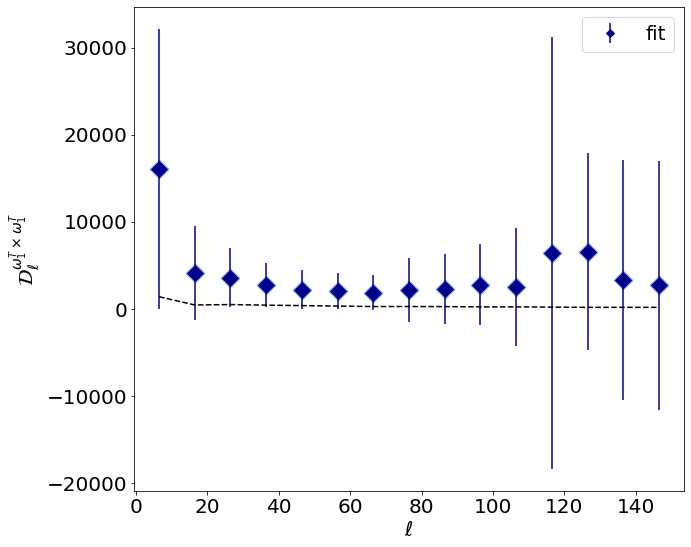

In [120]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'w1tw1t',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],get_dl_bb_mom(mom1t,mom1t)[:15],c='k',linestyle='--',label='analytical')
plt.show()

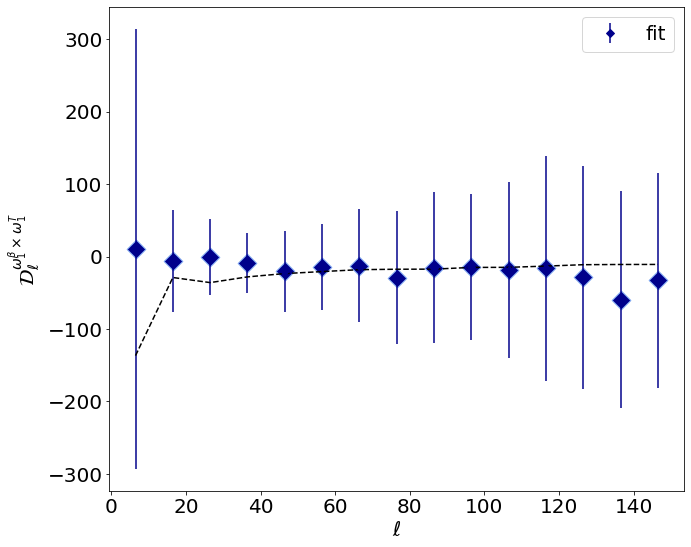

In [121]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'w1bw1t',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],get_dl_bb_mom(mom1b,mom1t)[:15],c='k',linestyle='--',label='analytical')
plt.show()

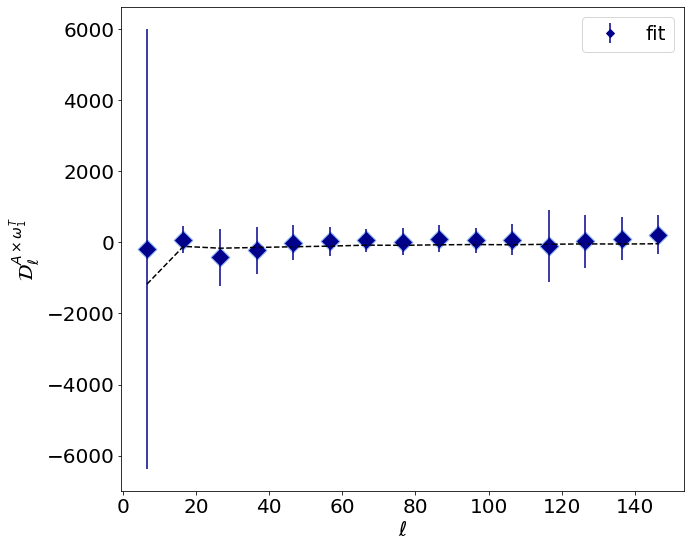

In [122]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'Aw1t',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,mom1t)[:15],c='k',linestyle='--',label='analytical')
plt.show()

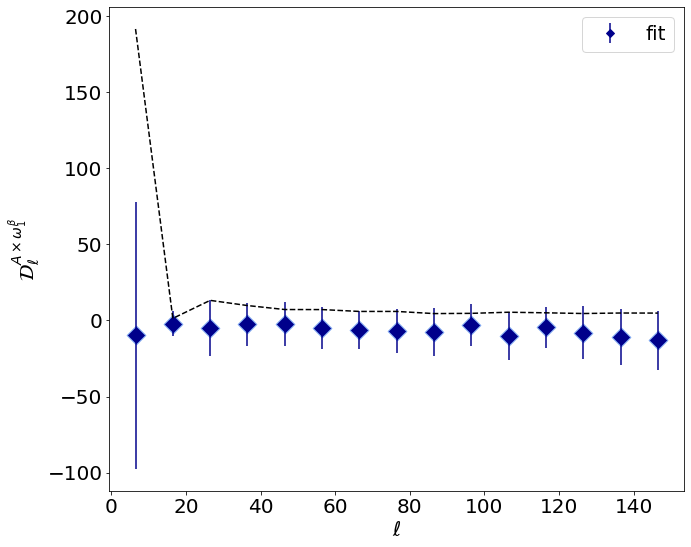

In [123]:
plt.figure(figsize=(10,8))
plotmed(leff[:15],'Aw1b',res,color='darkblue',marker="D",show=False,legend='fit')
plt.plot(leff[:15],get_dl_bb_mom(skyrefcpx,mom1b)[:15],c='k',linestyle='--',label='analytical')
plt.show()